In [4]:
import msprime, tskit
from IPython.display import SVG
import numpy as np
import matplotlib.pyplot as plt
from algorithm import *

In [5]:
ts2 = msprime.sim_ancestry(3, population_size=100, sequence_length=1e5, recombination_rate=1e-8,
                         record_full_arg=True)

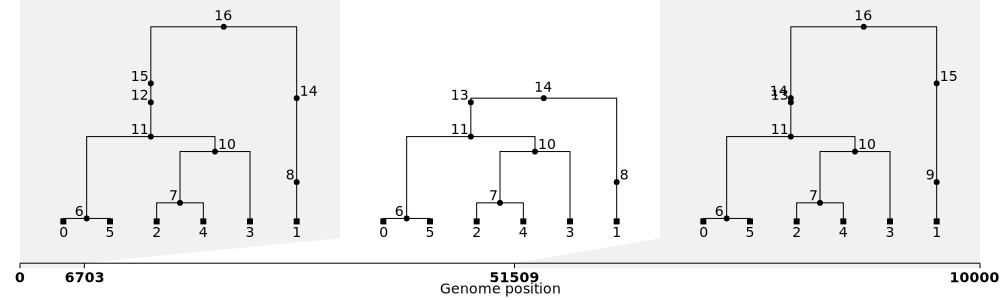

In [6]:
SVG(ts2.draw_svg(size=(1000, 300), x_lim=[0, 1e5]))

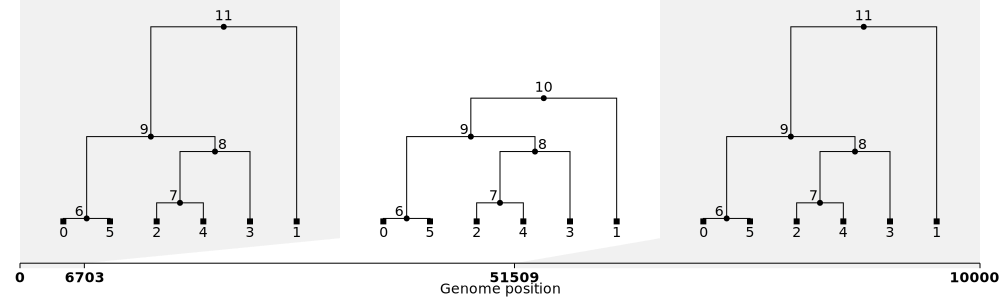

In [7]:
sts = ts2.simplify()
SVG(sts.draw_svg(size=(1000, 300), x_lim=[0, 1e5]))

[14]


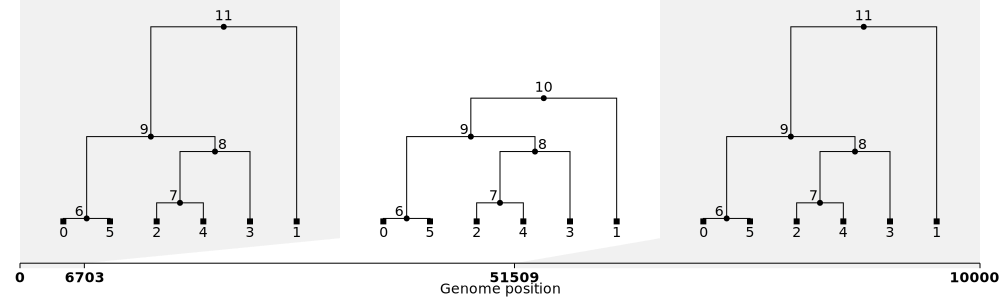

In [8]:
ts1, n = extend_edges(sts)
print(n)
SVG(ts1.draw_svg(size=(1000, 300), x_lim=[0, 1e5]))

## Original Discrepancy Function

Our goal is to construct a function to measure the amount of discrepancy between our inferred tree sequence $TS_1$ and the ground truth $TS_2$. Suppose that tree sequences $TS_1$ and $TS_2$, which are both of sequence length $L$, have nodes $x$ and $y$ in their respective trees at position $i$ in the genome. From these nodes we count the number of samples which inherit from them. We define these sets as $D_1(i,x)$ and $D_2(i,y)$. We can measure the discrepancy between the nodes $x$ and $y$ as the size of their set difference, $|D_1(i,x)\vartriangle D_2(i,y)|$. We define the $\textbf{discrepancy}$ between nodes $x$ and $y$ as 
$$ d(x,y) = \sum_{i=0}^{L-1} |D_1(i,x)\vartriangle D_2(i,y)|. $$
Using this we generalize to measure the discrepancy between a node $x$ and the ground truth $TS_2$,
$$ d(x,TS_2) = \min_{y} d(x,y) ,$$
where where the minimum is over nodes $y$ in $TS_2$.
Finally, to compute the number of discrepancies between tree sequences we use the function
$$d(TS_1,TS_2) = \sum_{x} d(x,TS_2)=\sum_{x} \inf_{y} d(x,y) = \sum_{x} \inf_{y} \sum_{i=0}^{L-1} |D_1(i,x)\vartriangle D_2(i,y)|,$$
and call this the $\textbf{discrepancy}$ between $TS_1$ and $TS_2$.

Note that discrepancy is like a *subset* operation - if $TS_1$ is "a subset" (defined appropriately)
of $TS_2$, then $d(TS_1, TS_2) = 0$.

In [10]:
def orig_node_discrepancy(x, ts1, y, ts2):
    # function to return the discrepancy number between two nodes, d(x,y)
    dis = 0
    for interval, t1, t2 in ts1.coiterate(ts2):
        s = interval.span
        Dx = set(t1.samples(x))
        for z in t2.samples(y):
            if z not in Dx:
                dis += s
    return dis

# Here are two implementations that should be the same thing and can be compared to each other

def orig_node_tree_discrepancy(x, ts1, ts2):
    dis = ts2.sequence_length
    for y in range(ts2.num_nodes):
        xydis = orig_node_discrepancy(x, ts1, y, ts2)
        if xydis < dis:
            dis = xydis
    
    return dis

def orig_node_tree_discrepancy2(x, ts1, ts2):
    dis = np.zeros(ts2.num_nodes)
    for interval, t1, t2 in ts1.coiterate(ts2):
        s = interval.span
        Dx = set(t1.samples(x))
        for y in t2.nodes():
            n = len(set(t2.samples(y)) - Dx)
            dis[y] += n * s
    return np.min(dis)

In [11]:
num_samples = 10
tsA = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=1e5,
                           recombination_rate=1e-8, record_full_arg=True)
tsB = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=1e5,
                           recombination_rate=1e-8, record_full_arg=True)
for j in range(10):
    assert np.all(orig_node_tree_discrepancy(j, tsA, tsA) == 0)
    assert np.all(orig_node_tree_discrepancy2(j, tsA, tsA) == 0)
    assert np.allclose(
        orig_node_tree_discrepancy(j, tsA, tsB),
        orig_node_tree_discrepancy2(j, tsA, tsB)
    )

In [12]:
def orig_discrepancy(ts1, ts2):
    dis = 0
    for n in range(ts1.num_nodes):
        dis += orig_node_tree_discrepancy2(n,ts1,ts2)
    return dis

In [13]:
orig_discrepancy(ts1, ts2)

0.0

Now we should run an experiment to see with our new metric the varying distribution of the discrepancy between the simulated tree sequence and its edge extended version.
If everything added in by extending edges was true,
then the discrepancy between the simplified-edge-extended tree sequence
and the original
should be zero;
any nonzero discrepancy indicates wrong guesses.

In [15]:
for num_samples in [3, 5,7,9]:
    for L in [1e4, 1e5]: #, 1e6,1e7]:
        ts = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=L,
                                  recombination_rate=1e-8, record_full_arg=True)
        sts = ts.simplify()
        
        ext_sts, _ = extend_edges(sts)
        #dd = orig_discrepancy(ext_sts, ts)
        d = orig_discrepancy(ext_sts, ts)
        print(f'number of samples = {num_samples}, length = {L}\n original discrepancy number = {d}')

number of samples = 3, length = 10000.0
 original discrepancy number = 0.0
number of samples = 3, length = 100000.0
 original discrepancy number = 0.0
number of samples = 5, length = 10000.0
 original discrepancy number = 0.0
number of samples = 5, length = 100000.0
 original discrepancy number = 0.0
number of samples = 7, length = 10000.0
 original discrepancy number = 0.0
number of samples = 7, length = 100000.0
 original discrepancy number = 0.0
number of samples = 9, length = 10000.0
 original discrepancy number = 0.0
number of samples = 9, length = 100000.0
 original discrepancy number = 3512.0


We see from the above we do not always infer perfectly (as expected), but usually do. The metric is also quite slow computationally, as computing the symmetric difference between pairwise sets of nodes slows us down significantly once we increase the length of the tree sequences to $L=10^7$. The computation time is roughly $n_1 n_2 t$, where $n_i$ is the number of nodes in tree sequence $T_i$ and $t$ is the number of trees. To reduce computation time we define a new discrepancy function below.

# Discrepancy Function (Take 2)

For a tree sequence $T$ and a node $x$ and position $i$, let $D_T(x, i)$ be the set of descendant
samples of $x$ in $T$ at position $i$, and for node $x$ in $T_1$ and node $y$ in $T_2$, where both $T_j$
are tree sequences of length $L$, let
$$
   \rho_{T_1, T_2}(x, y)
   =
   \frac{1}{L} \sum_i \left[ D_{T_1}(x, i) == D_{T_2}(y, i) \right],
$$
where the thing in the $[ ]$'s means that it should be 1 if True, 0 if False.
This is the fraction of the sequence along which $x$ and $y$ have exactly the same descendant set
(and so is a similiarity).
Then, let
$$
  \widehat{d}(x, T_1, T_2) = \min_y \left\{ 1 - \rho_{T_1, T_2}(x, y) \right\} ,
$$
which is the proportion of the genome over which the descendant set of $x$ *does not* match
that of $y$, where $y$ is it's (global) best matching node.

Note that this is *different* than
$$
   \frac{1}{L} \sum_i \min_y \left(1 - \left[ D_{T_1}(x, i) == D_{T_2}(y, i) \right]\right),
$$
which would tell us the proportion of the genome over which $x$ does not have a perfectly matching node,
i.e., a node which has exactly the same descendant set.

We are doing this because want to find the node $y$ that is the best match over the whole genome,
since this tells us how well nodes are identified across trees.

We then define the *discrepancy* between $T_1$ and $T_2$ to be 
$$
\widehat{d}(T_1,T_2) = \sum_{x\in T_1} \widehat{d}(x, T_1, T_2) .
$$

Note that the algorithm to compute this
is $n_1 t$, rather than $n_1 n_2 t$ as we had above,
because on each tree, for each node $x$,
we need only look at $O(1)$ nodes rather than all nodes.

In [23]:
def node_tree_discrepancy(x, ts1, ts2):
    # here sim[y] is the span so far over which y has the same set of descendants as x
    sim = np.zeros(ts2.num_nodes)
    #m = np.zeros(ts2.num_nodes)
    for interval, t1, t2 in ts1.coiterate(ts2):
        s = interval.span
        Dx = set(t1.samples(x))
        MRCA = t1.mrca(*list(Dx))
        #if len(Dx) == 0:
            #for y in t2.nodes():
                #m[y] += s
        if len(Dx) > 0:
            if len(Dx) == 1:
                y = list(Dx)[0]
            else:
                y = t2.mrca(*list(Dx))
            if set(t2.samples(y)) == Dx:
                sim[y] += s 
                y = t2.parent(y)
                if x != MRCA:
                    while y != tskit.NULL and set(t2.samples(y)) == Dx:
                        sim[y] += s
                        y = t2.parent(y)
    return ts1.sequence_length - np.max(sim)

In [8]:
def discrepancy(ts1, ts2):
    dis = 0
    for n in range(ts1.num_nodes):
        dis += node_tree_discrepancy(n, ts1, ts2)
    return dis

## Thoughts:

Here are some properties we'd like our dissimiarity to satisfy:

1. interpretable
2. computable
3. measuring what we want

More concretely,

- smaller changes to the trees should not have larger effects on dissimiliarity

Note that in the definition above, moving a bigger subtree actually has a larger effect on dissimiliarty
than moving a smaller subtree, because all nodes on the path from the old place the subtree was attached
to the new place are affected.

*Question:* What is a notion of monotonicity that we could use here (ie what's "smaller")?

Another observation:

- what if a node has an exact match to different other nodes on two halves of the genome;
   shouldn't this be better than if it just doesn't match anyone on half the genome?

*Note:* there are two dimensions here: sequence length; and how much descendant sets differ;
and there is some interplay between the two.

*Observation:* we could modify the definition above to be
$$
   \rho_{T_1, T_2}(x, y)
   =
   \frac{1}{L} \sum_i f(|D_{T_1}(x, i)|) \left[ D_{T_1}(x, i) == D_{T_2}(y, i) \right],
$$
for some function $f$ of the size of the set
(e.g., if $f(w) = 1/w$ then we'd be downweighting mismatches on large descendant sets,
which might make sense because if a node doesn't match then probably their descedant nodes don't match either).

*Note:* if you move a subtree, the discrepancy is monotone in the distance you move it.

### 3. Check $d(TS_1,TS_2) = d(TS_2,TS_1) = 0 \Longrightarrow TS_1=TS_2$, or 
### $d(TS_1,TS_2)=0 \Longrightarrow TS_1\subset TS_2$.
Suppose that $d(TS_1,TS_2)=d(TS_2,TS_1)=0$. Then we eventually do the math to make this check.


### 4. Make a plot of runtime of $d(TS_1,TS_2)$ as a function of number of nodes/trees/both.
We run some computations of our new discrepancy function below. 

In [22]:
for num_samples in [3, 5, 7, 9]:
    for L in [1e4, 1e5, 1e6,1e7]:
        ts = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=L,
                                  recombination_rate=1e-8, record_full_arg=True)
        sts = ts.simplify()
        
        ext_sts, _ = extend_edges(sts)
        d = discrepancy(ext_sts, ts)
        print(f'number of samples = {num_samples}, length = {L}\n original discrepancy number = {d}')

number of samples = 3, length = 10000.0
 original discrepancy number = 0.0
number of samples = 3, length = 100000.0
 original discrepancy number = 290861.0
number of samples = 3, length = 1000000.0
 original discrepancy number = 64965254.0
number of samples = 3, length = 10000000.0
 original discrepancy number = 4345347301.0
number of samples = 5, length = 10000.0
 original discrepancy number = 0.0
number of samples = 5, length = 100000.0
 original discrepancy number = 1154010.0
number of samples = 5, length = 1000000.0
 original discrepancy number = 78143011.0
number of samples = 5, length = 10000000.0
 original discrepancy number = 5907279811.0
number of samples = 7, length = 10000.0
 original discrepancy number = 0.0
number of samples = 7, length = 100000.0
 original discrepancy number = 243524.0
number of samples = 7, length = 1000000.0
 original discrepancy number = 67842228.0


KeyboardInterrupt: 